In [1]:
#coding=utf-8
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.patches as mpatches

from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import numpy as np
import pandas as pd

# Read raw data

In [2]:
## Load the train data
train = np.load("data/train.npz")
X_train, y_train = train["X"], train["y"]

## Load the test data
X_test = np.load("data/test.npz")["X"]


# Plot data representatives

In [3]:
# Arrange images as a 10x10 matrix with each class in the corresponding row.
image_shape = (28, 28)

N = y_train.shape[0]
image_classes = []

for target_class in range(10):
    class_inds = np.where(y_train == target_class)[0]
    # select 10 random sub inds 
    class_sub_inds = np.random.choice(class_inds, 10)
    image_classes.append(X_train[class_sub_inds, :])

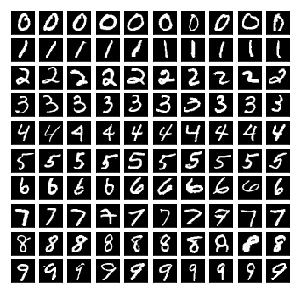

In [4]:
#plot selected representatives
n_row, n_col = 10, 10

plt.figure(figsize=(n_col/2, n_row/2))
for i in range (0, n_row):
    for j in range(0, n_col):
        plt.subplot(n_row, n_col, i * n_row + j + 1)
        plt.imshow(image_classes[i][j].reshape(image_shape), cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
# plt.tight_layout()

# Apply and plot PCA

In [5]:
from sklearn.decomposition import PCA

In [6]:
# make PCA embedding from 784d feature space into 2d space
pca = PCA(n_components=2)
sub_inds = np.random.choice(X_train.shape[0], 10000)
embedding = pca.fit_transform(X_train[sub_inds])

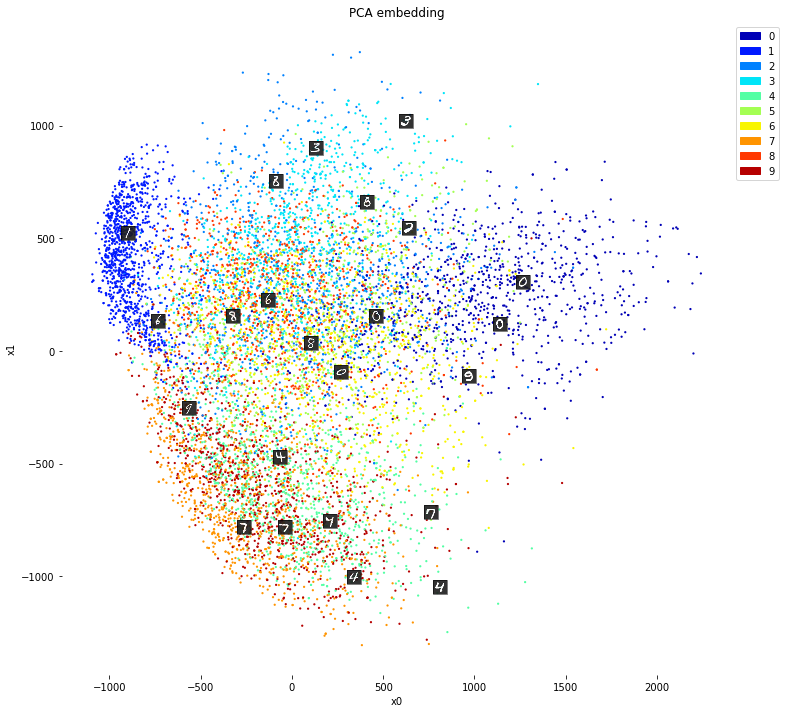

In [7]:
# plot embedding
x0 = [x[0] for x in embedding]
x1 = [x[1] for x in embedding]
colors = [cm.jet((y_ + 0.5)/10) for y_ in y_train[sub_inds]]
plt.figure(figsize=(12, 12))
ax = plt.axes(frameon=False)
plt.scatter(x0, x1, c=colors, edgecolor = 'none', s = 5)
patches = [mpatches.Patch(color=cm.jet((target_class + 0.5)/10), 
                          label=str(target_class)
                         ) 
           for target_class in range(10)]
# scatter some representatives
shown = [np.array([np.inf, np.inf])]
np.random.seed(1)
for i in np.random.choice(len(sub_inds), 35):
    imagebox = OffsetImage(X_train[sub_inds[i]].reshape(28, 28), cmap=plt.cm.gray, zoom = 0.5, alpha = 0.8)
    annbox = AnnotationBbox(imagebox, embedding[i], pad = 0.0, bboxprops={'alpha':0.5})
    dists = np.linalg.norm((np.array(shown) - embedding[i]), axis = 1)
    if np.min(dists) > 200: # this is needed to limit the minimum distance between representatives
        ax.add_artist(annbox)
        shown.append(embedding[i])
plt.draw()
plt.legend(handles=patches, loc = 2, bbox_to_anchor=(1.0, 1.0))
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('PCA embedding');

# Train model

split train set into sub_train and validation sets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
split_ = train_test_split(X_train, y_train, train_size = 0.1, random_state=1234)

X_train_train, X_train_val, y_train_train, y_train_val = split_

### logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
logit = LogisticRegression(penalty='l2', C = 1.0)

In [12]:
logit.fit(X_train_train, y_train_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
y_val_predicted = logit.predict(X_train_val)

In [14]:
accuracy = np.sum(y_val_predicted == y_train_val)/y_train_val.shape[0]
print(accuracy)

0.825981481481


### xgboost

In [15]:
import xgboost

In [16]:
xgbc = xgboost.XGBClassifier(n_estimators=10, 
                             max_depth=10,
                            learning_rate=0.1,
                            colsample_bytree = 0.3,
                            objective='multi:softmax')

In [17]:
xgbc.fit(X_train_train, y_train_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [18]:
y_val_predicted = xgbc.predict(X_train_val)

In [19]:
accuracy = np.sum(y_val_predicted == y_train_val)/y_train_val.shape[0]
print(accuracy)

0.920222222222


### logistic regression with features compression

Convolutional step

In [63]:
from scipy.signal import convolve2d

def conv2d(image, conv, normalize=False):
    conv_ = (conv / conv.sum(dtype=np.float)) if normalize else conv
    return convolve2d(image, conv_, mode='valid',
                      boundary='fill', fillvalue=0)

Max pooling: tak the max pixel value within an SxS **nonoverlapping sliding window**

In [64]:
from scipy.ndimage.filters import maximum_filter

def max_pool(image, size=3, step=None):
    result_ = maximum_filter(image, size=(size, size),
                             mode='constant', cval=0,
                             origin=0)

    # Compute the bounds of the new image which use the FULL S x S window
    #  `maximum_filter` centers the window approximately just at its centre.
    slice_ = slice(size // 2,
                   size // 2 - size + 1 if size > 2 else None,
                   size if not isinstance(step, int) else step)
    return result_[slice_, slice_]

2D Convoluton + Max_pooling layer

In [65]:
def c2dm(image, filters, size=3, normalize=False):
    """Image is HxW array, filters is FxSxS set of F different
    filters of size SxS.
    
    Filters are reversed in order to match the natural image directions.
    """
    return np.stack([max_pool(conv2d(image,
                                     filter_[::-1, ::-1],
                                     normalize=normalize),
                              size=size)
                     for filter_ in filters], axis=0)

Filter results

In [66]:
convolution_filter = np.array(
    [[0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0],
     [1, 1, 1, 1, 1],
     [0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0]], dtype=np.float)

plot example of compression

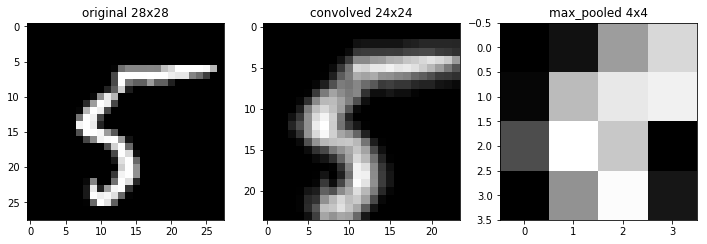

In [67]:
exemplar = image_classes[5][0].reshape(image_shape)

plt.figure(figsize = (12, 4))

#original
plt.subplot(1, 3, 1)
plt.imshow(exemplar, cmap=plt.cm.gray, interpolation='None')
plt.title('original ' + str(exemplar.shape[0]) + 'x' + str(exemplar.shape[1]))

#convolved
conv_exemplar = conv2d(exemplar, convolution_filter)
plt.subplot(1, 3, 2)
plt.imshow(conv_exemplar, cmap=plt.cm.gray, interpolation='None')
plt.title('convolved ' + str(conv_exemplar.shape[0]) + 'x' + str(conv_exemplar.shape[1]))

#pooled
pooled_conv_exemplar = max_pool(conv_exemplar, size=5)
plt.subplot(1, 3, 3)
plt.imshow(pooled_conv_exemplar, cmap=plt.cm.gray, interpolation='None')
plt.title('max_pooled ' + str(pooled_conv_exemplar.shape[0]) + 'x' + str(pooled_conv_exemplar.shape[1]))

Now let's compress all the training set

In [68]:
filters = np.array(
    [[[1, 1, 0, 0, 0],
      [1, 1, 1, 0, 0],
      [0, 1, 1, 1, 0],
      [0, 0, 1, 1, 1],
      [0, 0, 0, 1, 1]],

     [[0, 0, 0, 1, 1],
      [0, 0, 1, 1, 1],
      [0, 1, 1, 1, 0],
      [1, 1, 1, 0, 0],
      [1, 1, 0, 0, 0]],

     [[0, 0, 1, 1, 0],
      [0, 0, 1, 1, 0],
      [0, 1, 1, 1, 0],
      [0, 1, 1, 0, 0],
      [0, 1, 1, 0, 0]],

     [[ 0,  0, .5,  0,  0],
      [ 0, .5,  1, .5,  0],
      [.5,  1,  0,  1, .5],
      [ 0, .5,  1, .5,  0],
      [ 0,  0, .5,  0,  0]],
    ], dtype=np.float)

In [77]:
X_train_convolved = []
for i in range(X_train.shape[0]):
    if i % 1000 == 0:
        print('.',end='')
    exemplar = X_train[i].reshape(image_shape)
    # conv_exemplar = max_pool(conv2d(exemplar, convolution_filter))
    conv_exemplar = c2dm(exemplar, filters, size=3, normalize=True)
    X_train_convolved.append(conv_exemplar.flatten())
X_train_convolved = np.array(X_train_convolved)

............................................................

In [78]:
split_ = train_test_split(X_train_convolved, y_train, train_size=0.1, random_state=123)

X_train_train, X_train_val, y_train_train, y_train_val = split_

In [83]:
logit = LogisticRegression(penalty='l2', C = 1.0)

In [84]:
logit.fit(X_train_train, y_train_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [85]:
y_val_predicted = logit.predict(X_train_val)

In [86]:
accuracy = np.mean(y_val_predicted == y_train_val)
print(accuracy)

0.931037037037


In [79]:
xgbc = xgboost.XGBClassifier(n_estimators=250, 
                             max_depth=3,
                             learning_rate=0.1,
                             colsample_bytree=0.3,
                             objective='multi:softmax')
xgbc.fit(X_train_train, y_train_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [80]:
y_val_predicted = xgbc.predict(X_train_val)

In [81]:
accuracy = np.mean(y_val_predicted == y_train_val)
print(accuracy)

0.951962962963


# Play

In [ ]:
# your code here

# Make submission

In [ ]:
## Make a submission
y_pred = model.predict(X_test)
sub_ = pd.DataFrame.from_items([("id", np.arange(X_test.shape[0], dtype=np.int)),
                                ("label", y_pred)])
sub_.to_csv("submission.csv", index=False)